## Puzzles

In [1]:
import zlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import awkward as ak
import uproot

<br><br><br>

### Puzzle 1

In [2]:
array3d = np.arange(2 * 3 * 5).reshape(2, 3, 5)

#### Solution

Either keep the number of dimensions intact (the first dimension has length 1):

In [3]:
array3d[:1, :, 2:]

array([[[ 2,  3,  4],
        [ 7,  8,  9],
        [12, 13, 14]]])

or reduce that dimension:

In [4]:
array3d[0, :, 2:]

array([[ 2,  3,  4],
       [ 7,  8,  9],
       [12, 13, 14]])

These are different answers to the question, but both are fine.

<br><br><br>

### Puzzle 2

In [5]:
array = np.array([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

#### Solution

This involves slicing and applying a [universal function](https://numpy.org/doc/stable/reference/ufuncs.html) across all elements, showing how NumPy's elementary operations can be combined to get functionality that wasn't explicitly compiled into the library.

In [6]:
array[1:] - array[:-1]

array([1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1])

<br><br><br>

### Puzzle 3

In [7]:
t = np.linspace(0, 2*np.pi, 10000)
x = np.sin(3*t)
y = np.sin(4*t)

#### Solution

This calculation of path length involves slicing, universal functions, and reduction.

In [8]:
np.sum(np.sqrt((x[1:] - x[-1:])**2 + (y[1:] - y[-1:])**2), axis=0)

9564.961050220914

<br><br><br>

### Puzzle 4

In [9]:
image = matplotlib.image.imread("data/sun-shines-in-CMS.jpg")

#### Solution

In NumPy, the shapes of arrays are fluid. An array can be reshaped from 3 dimensional to 5 dimensional as long as the number of items is unchanged.

Reshaping provides new axes for reducers like [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) to apply.

Be sure to average over axis 3 before axis 1, since reduction removes an axis, changing the numbering of later axes.

In [10]:
resampled = np.mean(
    np.mean(
        image.reshape(1920 // 64, 64, 2560 // 64, 64, 3),
        axis=3,
    ),
    axis=1,
)

Or alternatively, use negative axis numbers and do it in the other order.

In [11]:
resampled = np.mean(
    np.mean(
        image.reshape(1920 // 64, 64, 2560 // 64, 64, 3),
        axis=-4,
    ),
    axis=-2,
)

Or as a third option, use `keepdims=True` to keep the axis numbering from changing and only remove the length 1 dimensions after all reductions are done.

In [12]:
resampled = np.mean(
    np.mean(
        image.reshape(1920 // 64, 64, 2560 // 64, 64, 3),
        axis=1,
        keepdims=True,
    ),
    axis=3,
    keepdims=True,
).reshape(1920 // 64, 2560 // 64, 3)

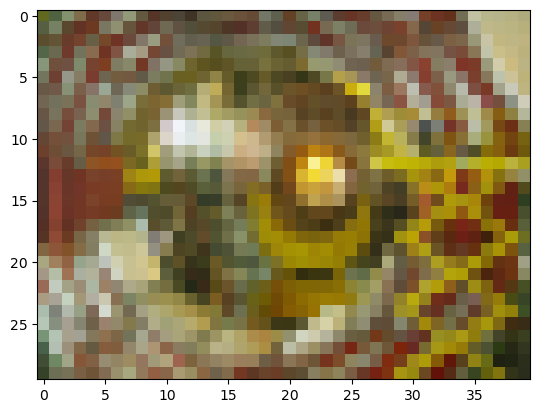

In [13]:
plt.imshow(resampled.astype(np.uint8));

<br><br><br>

### Puzzle 5

In [14]:
with open("data/SMHiggsToZZTo4L.root", "rb") as file:
    file.seek(42104123)
    compressed_data = file.read(14718)
    uncompressed_data = uncompressed_data = zlib.decompress(compressed_data)
    array_of_uint8 = np.frombuffer(uncompressed_data, np.uint8, 12524)

#### Solution

This is similar to the image-scaling puzzle: we use short-lived axes to be able to express an operation, but instead of reduction, it's a direction-reversing slice. Without reshaping, we wouldn't be able to express "groups of 4."

In [15]:
byte_swapped = array_of_uint8.reshape(-1, 4)[:, ::-1].reshape(-1)

In [16]:
byte_swapped.view(np.float32)

array([ 9.831079 , 12.383099 , 12.991788 , ...,  4.3587666,  5.632667 ,
        4.7507796], dtype=float32)

<br><br><br>

### Puzzle 6